In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
import random
import scipy
import time
import pandas as pd
from odeintw import odeintw
import pytwalk as twalk
sns.set_style('darkgrid')

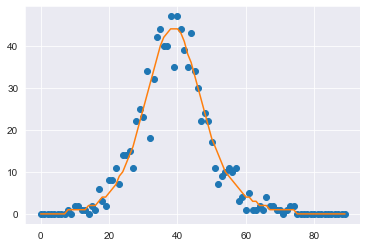

In [23]:
txt = np.loadtxt('datos_inci.txt', skiprows = 0) 
txt_round = np.round(txt)
#Agrego Ruido (con la misma semilla) para obtener mis datos
np.random.seed(123)
data = scipy.stats.poisson.rvs(txt_round)
#Grafico
plt.plot(data,'o')
plt.plot(txt_round)
plt.show()

In [24]:
n = int(input('¿Cuántos compartimentos de E quieres, V?'))

¿Cuántos compartimentos de E quieres, V? 1


### Modelo

1. Cuando n = 1 -> SEYIR
2. Cuando n > 1 -> SEnIR_Cox

Argumentos:

1. X: Vector de Estados. Dimensión =  n+4
2. t: Vector de Tiempo (medido en días). 90 días
3. theta: Vector de parámetros. Ejemplo, cuando n=3 entonces
$$
\theta = (\beta, \gamma, \lambda, p_{1},p_{2})
$$

In [25]:
def SEYIR(X,t,theta):  
    S,E,Y,I,R = X
    dS = -theta[0]*I*S/N
    dE = (theta[0]*I*S)/N-(theta[2]*E)
    dY = theta[2]*E
    dI = theta[2]*E-theta[1]*I
    dR = theta[1]*I
    return [dS,dE,dY,dI, dR]

def SEnIR_Cox(X,t,theta):
    N = 1000
    diag0 = np.append(theta[0], theta[2]*(1-np.append(theta[3],1)))
    diag1 = -theta[2]
    tt = np.diag(diag0)+np.diag(diag1,1)
    tt = np.delete(tt, n, axis=0)
    a = X[0]*X[n+1]/N 
    XX = np.append(a,X[1:n+1])
    dS = -theta[0]*a
    dE = tt@XX
    dY = np.sum(theta[2]*np.append(theta[3],1)*X[1:n+1])
    dI = np.sum(theta[2]*np.append(theta[3],1)*X[1:n+1])-theta[1]*X[n+1]
    dR = theta[1]*X[n+1]
    sols = np.append(dS,dE)
    sols = np.array(np.append(sols,[dI,dY,dR]))
    return(sols)

### Supuestos para la inferencia

0. Datos Generales

In [33]:
## No. de pobladores ( Se supone una población cerrada durante)
N = 1000

## Tiempo en el que se reune la data
dias = 90
t = np.linspace(0,dias,dias+1)

### Condiciones Iniciales
X0_1 = [(N -1), 1, 1, 0, 0]  ### si n = 1
S0 = N-1.
E0 = [0] * n 
E0[0] = 1.
I0 = 0.
Y0 = 1.
R0 = 0.
X0_2 = [S0]+E0+[I0,Y0,R0]  ### si n > 1

1. D. Aprioris: Se suponen V.A. independientes con distribuciones Gamma(1,0.6) los siguientes parámetros: $\beta, \gamma, \lambda$ y Beta(20,1) los parametros $p_{1},p_{2},\dots$.

In [27]:
## Hiperparámetros:
gamma_hiper = [1,0.6]
beta_hiper = [10,1]

In [32]:
def logprior(theta):
    db = scipy.stats.gamma.logpdf(theta[0],gamma_hiper[0],0,gamma_hiper[1])
    dg = scipy.stats.gamma.logpdf(theta[1],gamma_hiper[0],0,gamma_hiper[1])
    dl = scipy.stats.gamma.logpdf(theta[2],gamma_hiper[0],0,gamma_hiper[1])
    if n==1:
        return(db+dg+dl)
    else:
        dp == 0
        for i in range(0,n):
            dp += scipy.stats.beta.logpdf(theta[i+3],beta_hiper[0],beta_hiper[1])
        return(db+dg+dl+dp)

2. Verosimilitud: Se supone que los datos tienen una d poisson con media la incidencia obtenida del modelo

In [34]:
def logver(theta):
    if n==1:
        # Condición inicial
        X0 = X0_1
        # se resuelve el modelo
        Xt = odeint(SEYIR,X0,t, args=(theta,))
        # Incidencia
        Inct = np.diff(Xt[:,2])

    else:
        # Condición Inicial
        X0 = X0_2
        # Se construye el vector de parámetros en el formato que lo necesita la función
        eles = np.repeat(params[2],n)
        pes = np.array([params[3:]])
        theta = np.array([params[0],params[1],eles,pes])
        # Se resuelve el modelo
        Xt = odeintw(SEnIR_Cox,X0,t, args=(theta,))
        # Incidencia
        Inct = np.diff(Xt[:,n+2])
        
    # Logverosimilitud
    ver = 0
    for i in range(0,len(data)):
        ver += scipy.stats.poisson.logpmf(data[i],mu=Inct[i])
    return(ver)

3. Función de energía, la cual se define como $$ U(\theta|y) = -Log(f(theta|y))$$
donde $f(theta|y)$ es la distrubución posterior y $y$ el vector de datos.

In [35]:
def U(theta):
    return(-logprior(theta)-logver(theta))

### Requisitos para el Algoritmo T Walk

In [39]:
### Función que retorna True si las cadenas se mueven dentro del soporte de cada parámetro, False si no
def Supp(theta):
    if n == 1:
        if (theta[0]<0 and theta[1]<0 and theta[2]<0):
            return False
        else:
            return True
    else:
        if (theta[0]<0 and theta[1]<0 and theta[2]<0 and np.any(theta[3:]<0) and np.any(theta[3:]>1 )):
            return False
        else:
            return True

In [40]:
### Función de valores iniciales de cada cadena
def p0():
    b = scipy.stats.gamma.rvs(a=b_hiper[0], loc = 0,scale = b_hiper[1],size = 1)
    g = scipy.stats.gamma.rvs(a=g_hiper[0], loc = 0,scale = g_hiper[1],size = 1)
    l = scipy.stats.gamma.rvs(a=l_hiper[0], loc = 0,scale = l_hiper[1],size = 1)
    vec = [b[0],g[0],l[0]]
    if n > 1:
        for i in range(0,n):
            temp = scipy.stats.beta.rvs(p_hiper[0],p_hiper[1])
            vec = vec + temp
    return(np.array(vec))

### Corre T Walk

In [43]:
inicio = time.time()    ## para contar cuanto tiempo tarda
T = 10000               ## no. de iteraciones
x0 = p0()               ## vals iniciales
xp0 = p0()
np.random.seed(123)     ## semilla
m = n+4                 ## no. de parametros a estimar
tchain = twalk.pytwalk( n=m, U=U, Supp=Supp )  
tchain.Run( T=T , x0= x0 , xp0= xp0)
final = time.time() - inicio

In [20]:
output=tchain.Output[:, 0:m ]
mat = np.matrix(output)       ### hago una matriz de Txm

0.9461610317230225


In [44]:
### Ejemplo de como guardar las cadenas
##np.savetxt('Cox1_Cadenas_ruido.txt',mat,fmt =' %.15e', delimiter=' ')